In [206]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import time
import json

%matplotlib inline

In [2]:
from file_processing import *

In [211]:
org_dataset_path = 'data/categories_castle_cafe/categories_blurred_photos_removed/'

In [212]:
dataset_path = 'data/categories_castle_cafe/categories_blurred_photos_removed_small/'

In [213]:
# org_dataset_path = 'data/categories_castle_cafe/categories_blurred_photos_removed_multiple_hold_imgs/'

In [214]:
# dataset_path = 'data/categories_castle_cafe/categories_blurred_photos_removed_multiple_hold_imgs_small/'

In [217]:
for c in range(1, 47): 
    c_path = os.path.join(dataset_path, str(c))
    files = get_filenames(c_path)
    for i, f in enumerate(files):
        compress_and_save(os.path.join(org_dataset_path, str(c), f), os.path.join(dataset_path, str(c), f))

In [34]:
img = cv2.imread(os.path.join(dataset_path, '1/IMG_20191124_204714689.jpg'))

In [35]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [36]:
orb = cv2.ORB_create()

In [37]:
key_points, description = orb.detectAndCompute(img, None)

In [38]:
img_keypoints = cv2.drawKeypoints(img,
                                  key_points,
                                  img,
                                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

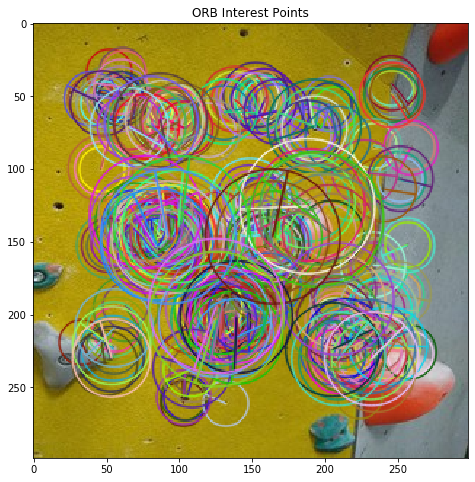

In [39]:
plt.figure(figsize=(8, 8))
plt.title('ORB Interest Points')
plt.imshow(img_keypoints); plt.show()

In [218]:
def image_detect_and_compute(detector, img_name):
    """Detect and compute interest points and their descriptors."""
    img = cv2.imread(os.path.join(dataset_path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # The performance is lowered if I use grayscale
    kp, des = detector.detectAndCompute(img, None)
    return img, kp, des
    

def draw_image_matches(detector, img1_name, img2_name, nmatches=10):
    """Draw ORB feature matches of the given two images."""
    img1, kp1, des1 = image_detect_and_compute(detector, img1_name)
    img2, kp2, des2 = image_detect_and_compute(detector, img2_name)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x: x.distance) # Sort matches by distance.  Best come first.
    
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:nmatches], img2, flags=2) # Show top 10 matches
    print('Total distance:')
    print(sum([x.distance for x in matches[:nmatches]]))
    plt.figure(figsize=(8, 8))
    plt.title(type(detector))
    plt.imshow(img_matches); plt.show()
    return sum([x.distance for x in matches[:nmatches]])

In [219]:
def match_img(matcher, orb, img_name, descriptors, nmatches):
    _, _, des = image_detect_and_compute(orb, img_name)
    dists = {}
    for file_name, des_i in descriptors.items():
        if img_name!=file_name: # prevent matching on itself
#             start = time.time()
            matches = matcher.match(des, des_i)
#             print(f" match time elapsed: {time.time() - start}")
#             start = time.time()
            matches = sorted(matches, key = lambda x: x.distance)
#             print(f" sort time elapsed: {time.time() - start}")
#             start = time.time()
            dist = sum([x.distance for x in matches[:nmatches]])
#             print(f" sum time elapsed: {time.time() - start}")
            dists[file_name] = dist
    return dists

In [220]:
def get_min_dists(d):
    min_dists = {}
    for c_f, v in d.items():
        min_dist_key = min(v, key=v.get)
        min_dist_dist = min(v.values())
        min_dist_c = min_dist_key.split('/')[0]
        min_dists[c_f] = [min_dist_c, min_dist_dist]
    return min_dists

def distinct(seq):
    # distinct elements in list preserving order
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def get_top_n(d, n=3):
    top_n = {}
    for c_f, v in d.items():
        s = sorted(v, key=v.get)
        distinct_s = distinct([i.split('/')[0] for i in s])  # gets the category out of the image file name
        top_n[c_f] = distinct_s[:n]
    return top_n
    
def get_stats(d):
    min_dists = get_min_dists(d)
    correct = []
    wrong = []
    for c_f, v in min_dists.items():
        if c_f.split('/')[0] == v[0]:
            correct.append(v[1])
        else:
            wrong.append(v[1])   
    max_correct = max(correct)
    print(f"Max correct: {max_correct}")
    min_wrong = min(wrong)
    print(f"Min wrong: {min_wrong}")
    print(f"Total number of images: {(len(correct)+len(wrong))}")
    print(f"Number wrong: {len(wrong)}")
    number_wrong_below_threshold = len([x for x in wrong if x<max_correct])
    print(f"Number wrong below threshold: {number_wrong_below_threshold}")
    print(f"% wrong below max correct: {round(number_wrong_below_threshold/(len(correct)+len(wrong)), 2)*100}%")
    print(f"% wrong overall: {round(len(wrong)/(len(correct)+len(wrong)), 2)*100}%")
    top_n = get_top_n(d)
    correct_top_3 = []
    wrong_top_3 = []
    for c_f, cats in top_n.items():
        if any(i==c_f.split('/')[0] for i in cats):
            correct_top_3.append(c_f)
        else:
            wrong_top_3.append(c_f)  
    print(f"% wrong overall top 3: {round(len(wrong_top_3)/(len(correct_top_3)+len(wrong_top_3)), 2)*100}%")

Run from here

In [221]:
descriptors = {}

In [222]:
# Get all descriptors
start = time.time()
orb = cv2.ORB_create()
for c in range(1, 47): 
    c_path = os.path.join(dataset_path, str(c))
    files = get_filenames(c_path)
    for i, f in enumerate(files):
        _, _, des = image_detect_and_compute(orb, f'{c}/{f}')
        descriptors[f'{c}/{f}'] = des
print(f"Time elapsed: {time.time() - start}")

Time elapsed: 6.527603387832642


In [223]:
# Match one image
start = time.time()
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
dists = match_img(bf, orb, '1/IMG_20191215_092128.jpg', descriptors, 5)
print(f"Time elapsed: {time.time() - start}")

Time elapsed: 0.436626672744751


In [224]:
# Match all images
d = {}
start = time.time()
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for c in range(1, 47): 
    c_path = os.path.join(dataset_path, str(c))
    files = get_filenames(c_path)
    for i, f in enumerate(files):
        dists = match_img(bf, orb, f'{c}/{f}', descriptors, 5)
        d[f'{c}/{f}'] = dists
print(f"Time elapsed: {time.time() - start}")

Time elapsed: 175.63456392288208


In [225]:
get_stats(d)

Max correct: 176.0
Min wrong: 71.0
Total number of images: 329
Number wrong: 15
Number wrong below threshold: 12
% wrong below max correct: 4.0%
% wrong overall: 5.0%
% wrong overall top 3: 4.0%


11% wrong with grayscale

6% wrong with RGB, 32 sec

15% wrong with k=2 and 0.93 distance param which gives the same number of matches

6% wrong with k=2 and 0.85 distance param which gives the half the number of matches; 41 sec

Based on this the ratio test doesn't seem worth it, we can use the corss check as an alternative

1 - 2 - 1% wrong after cleaning out holds with just one photo
1-2-1 wrong after choosing top 5 matches

In [89]:
min_dists = get_min_dists(d)

In [98]:
correct = []
wrong = []
wrong_dists = []
for c_f, v in min_dists.items():
    if c_f.split('/')[0] == v[0]:
        correct.append(v[1])
    else:
        wrong.append(c_f) 
        wrong_dists.append(v[1]) 

In [91]:
wrong

['13/IMG_20191215_092338565.jpg',
 '18/IMG_20191215_092307.jpg',
 '19/IMG_20191212_215335949.jpg',
 '29/IMG_20191212_215605.jpg',
 '39/IMG_20191212_215717.jpg']

In [53]:
min_dists

{'1/IMG_20191212_215229.jpg': ['1', 164.0],
 '1/IMG_20191124_204712534.jpg': ['1', 197.0],
 '1/IMG_20191212_215101336.jpg': ['1', 164.0],
 '1/IMG_20191124_204456.jpg': ['1', 73.0],
 '1/IMG_20191215_092128.jpg': ['1', 134.0],
 '1/IMG_20191124_204455.jpg': ['1', 73.0],
 '1/IMG_20191124_204458.jpg': ['1', 93.0],
 '1/IMG_20191215_092201416.jpg': ['1', 134.0],
 '1/IMG_20191124_204714689.jpg': ['1', 175.0],
 '1/IMG_20191212_215744274.jpg': ['1', 176.0],
 '1/IMG_20191124_204716712.jpg': ['1', 175.0],
 '2/IMG_20191124_204509.jpg': ['2', 78.0],
 '2/IMG_20191124_204726948.jpg': ['2', 208.0],
 '2/IMG_20191124_204724144.jpg': ['2', 303.0],
 '2/IMG_20191215_092206765.jpg': ['2', 167.0],
 '2/IMG_20191212_215750365.jpg': ['2', 141.0],
 '2/IMG_20191124_204511.jpg': ['2', 78.0],
 '2/IMG_20191212_215243.jpg': ['2', 144.0],
 '2/IMG_20191124_204513.jpg': ['2', 89.0],
 '2/IMG_20191124_204729508.jpg': ['2', 241.0],
 '2/IMG_20191215_092136.jpg': ['2', 144.0],
 '2/IMG_20191212_215109986.jpg': ['2', 141.0],
 '

Total distance:
433.0


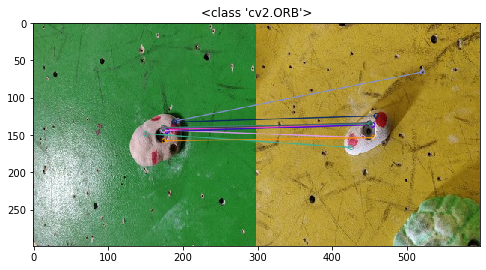

In [83]:
orb = cv2.ORB_create()
des = draw_image_matches(orb, '29/IMG_20191212_215605.jpg', '39/IMG_20191212_215717.jpg')

Total distance:
371.0


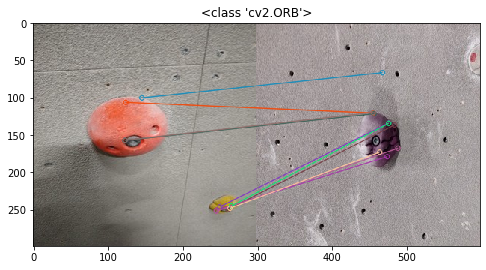

In [77]:
orb = cv2.ORB_create()
des = draw_image_matches(orb, '19/IMG_20191212_215335949.jpg', '18/IMG_20191124_204853.jpg')

Total distance:
538.0


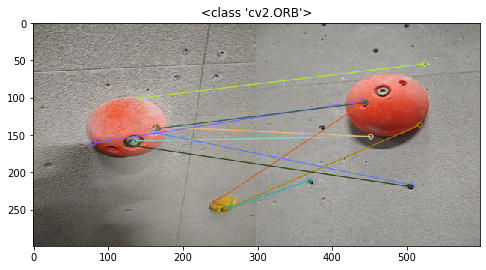

In [79]:
orb = cv2.ORB_create()
des = draw_image_matches(orb, '19/IMG_20191212_215335949.jpg', '19/IMG_20191124_205053860.jpg')

Total distance:
153.0


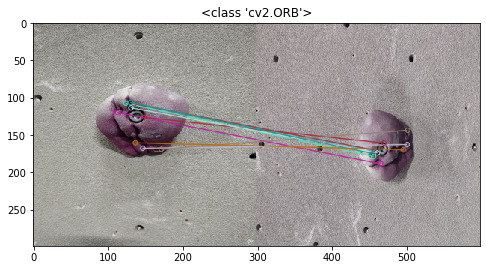

In [57]:
orb = cv2.ORB_create()
des = draw_image_matches(orb, '13/IMG_20191215_092338565.jpg', '18/IMG_20191215_092307.jpg')

From this analysis I would say there is only one wrong - the orange - purple match. The rotation there is quite strange, but still the colour and everyting could have helped.
The others are pretty much the same hold. 

Ideas:
- Object detection ot find the hold first and so extract its colour
- Average colour in order to detect the background

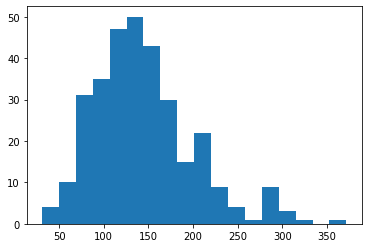

In [97]:
import matplotlib.pyplot as plt
_ = plt.hist(correct, bins='auto')
# np.histogram(correct)

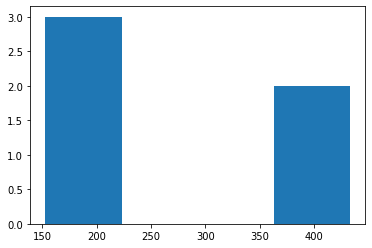

In [99]:
_ = plt.hist(wrong_dists, bins='auto')
# np.histogram(correct)

HIstogram of matches themselves of two images

Here it's saying 64 is a good threshold
https://stackoverflow.com/questions/22857398/matching-orb-features-with-a-threshold

In [102]:
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(descriptors['1/IMG_20191212_215229.jpg'], descriptors['1/IMG_20191124_204712534.jpg'])
matches = sorted(matches, key = lambda x: x.distance)

In [104]:
matches_dists = [x.distance for x in matches]

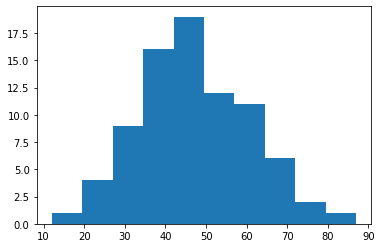

In [106]:
_ = plt.hist(matches_dists, bins='auto')


Compressing

In [150]:
img = cv2.imread(os.path.join(org_dataset_path, '1/IMG_20191215_092201416.jpg'))
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 90]
result, encimg = cv2.imencode('.jpg', img, encode_param)

In [ ]:
encimg.imwrite(os.path.join(org_dataset_path, 'compressed.jpg'))

Creating descriptors for test data

In [226]:
route_images = pd.read_csv('route_images.csv')

In [227]:
route_images['imagefilename'] = route_images.path.apply(lambda x: x.split('/')[8].replace('_IMG', '/IMG'))

In [228]:
route_images = route_images.set_index('imagefilename')

In [229]:
resources_d = {k:json.dumps(v.tolist()) for k, v in descriptors.items() if k in route_images.index.tolist()}

In [230]:
s = pd.DataFrame.from_dict(resources_d, orient='index', columns=['descriptors'])

In [231]:
route_images['descriptors'] = s.descriptors

In [232]:
route_images.head(1)

,user_route_id,model_route_id,user_id,model_probability,model_version,path,created_at,descriptors
imagefilename,,,,,,,,
1/IMG_20191215_092128.jpg,1,1,1,1.0,dummy_version,s3://climbicus-{ENV}/route_images/dummy_data/1...,2020-02-15 09:00:00+0,"[[164, 108, 136, 183, 204, 47, 207, 144, 154, ..."


In [234]:
route_images.descriptors.isnull().sum()

0

In [235]:
route_images.to_csv('route_images_with_descriptors.csv', index=False)